# Multimodal RAG using LlamaIndex, CLIP, & KDB.AI

Note: This example requires KDB.AI server. Sign up for a free [KDB.AI account](https://kdb.ai/offerings/).

This example explores preparing, embedding (with CLIP), and storing both text and image data within a KDB.AI vector database using LlamaIndex.

## Install dependencies

In [ ]:
!pip install llama-index llama-index-embeddings-huggingface llama-index-llms-openai llama-index-readers-file llama-index-vector-stores-kdbai llama-index-embeddings-clip
!pip install llama-index-embeddings-clip
!pip install 'git+https://github.com/openai/CLIP.git'
!pip install kdbai_client matplotlib wikipedia tqdm

## Download data

**Libraries**

In [2]:
import os
from tqdm import tqdm
import wikipedia
import urllib.request

**Data directories and paths**

In [3]:
# Root path
root_path = os.path.abspath(os.getcwd())

# Data directory and path
data_dir = "data"
data_path = os.path.join(root_path, data_dir)
if not os.path.exists(data_path):
    os.mkdir(data_path)

**Download data - wikipedia images & texts**

In [4]:
def download_data(WIKI_TITLES, MAX_IMAGES_PER_TITLE):
    # Text metadata
    text_uuid = 0
    text_metadata = dict()

    # Image metadata
    image_uuid = 0
    image_metadata = dict()

    # Download data - text and images from wiki pages
    for title in tqdm(WIKI_TITLES):
        images_per_wiki_page = 0
        print(title)
        try:
            wiki_page = wikipedia.page(title)

            # Text - data and metadata
            text_uuid += 1
            page_content = wiki_page.content

            content_path = os.path.join(data_path, f"{title}.txt")
            with open(content_path, 'w') as f:
                f.write(page_content)
            text_file_name = f"{title}.txt"

            text_metadata[text_uuid] = {
                "filename": text_file_name,
                "file_path": content_path
            }

            list_img_urls = wiki_page.images
            for url in list_img_urls:
                if url.endswith(".jpg") or url.endswith(".png"):
                    # Limiting images to downloaded per wikipedia page
                    images_per_wiki_page += 1
                    if images_per_wiki_page > MAX_IMAGES_PER_TITLE:
                        break

                    # Image - data and metadata
                    image_uuid += 1
                    image_path = os.path.join(data_path, f"{image_uuid}.jpg")
                    image_file_name = f"{image_uuid}.jpg"

                    urllib.request.urlretrieve(
                        url, image_path
                    )

                    image_metadata[image_uuid] = {
                        "filename": image_file_name,
                        "file_path": image_path,
                    }
        except Exception:
            print(str(Exception("No images found for Wikipedia page: ")) + title)
            continue

    return image_metadata, text_metadata

In [5]:
# Wikipedia titles to retrieve data & max images per title to retrieve
WIKI_TITLES = [
    "Machiavelli",
    "Beethoven",
    "Burj khalifa",
    "Cherry Blossom",
    "Video Game"
]
MAX_IMAGES_PER_TITLE = 10

# Download the data if not downloaded yet
image_metadata, text_metadata = download_data(WIKI_TITLES, MAX_IMAGES_PER_TITLE)

  0%|          | 0/5 [00:00<?, ?it/s]

Machiavelli


 20%|██        | 1/5 [00:08<00:32,  8.09s/it]

Beethoven


 40%|████      | 2/5 [00:12<00:18,  6.18s/it]

Burj khalifa


 60%|██████    | 3/5 [00:16<00:09,  4.95s/it]

Cherry Blossom


 80%|████████  | 4/5 [00:18<00:03,  3.93s/it]

No images found for Wikipedia page: Cherry Blossom
Video Game


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]

No images found for Wikipedia page: Video Game


**Resize Images**

In [6]:
import os
import math
from PIL import Image
from tqdm import tqdm

In [7]:
def resize_images(data_path):
    for file in tqdm(os.listdir(data_path)):
        if file.endswith('.jpg'):
            img_path = os.path.join(data_path, file)
            img = Image.open(img_path)
            img_width, img_height = img.size
            aspect_ratio = img_width/img_height

            if img_width > 2048:
                new_width = 2048
                new_height = round(new_width/aspect_ratio)

                img = img.resize((new_width, new_height))
                img.save(img_path)

In [8]:
resize_images(data_path)

100%|██████████| 37/37 [00:05<00:00,  6.61it/s]


**Show images**

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import os

In [10]:
def show_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16,9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown+1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

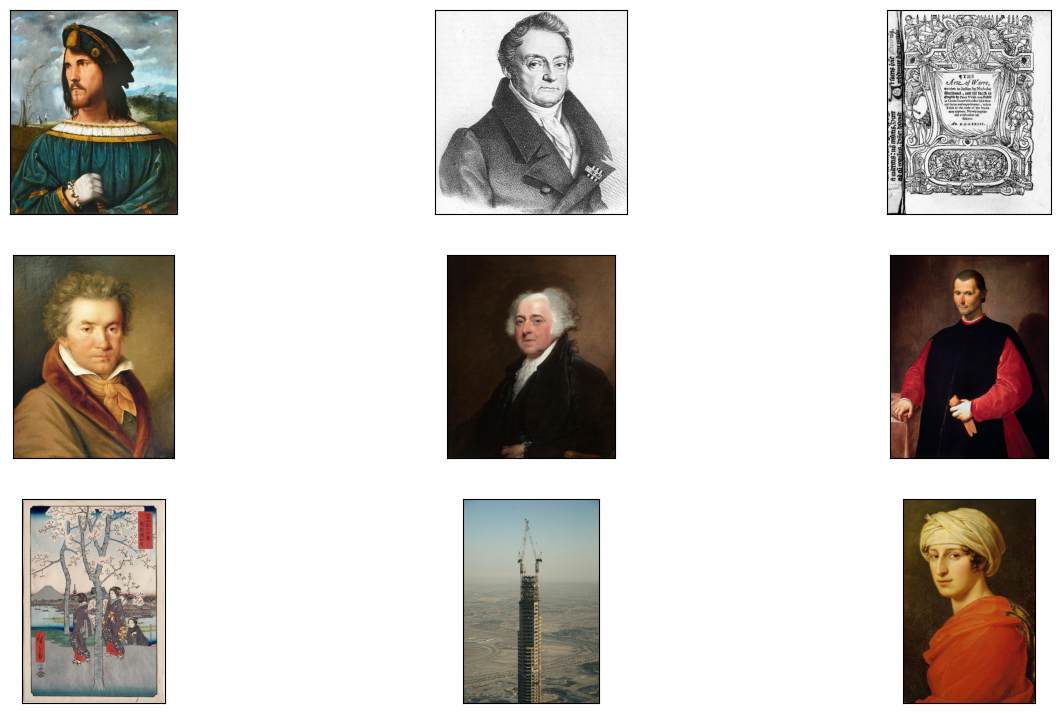

In [11]:
image_paths = []
for file in os.listdir(data_path):
    if file.endswith('.jpg'):
        img_path = os.path.join(data_path, file)
        image_paths.append(img_path)
show_images(image_paths)

**Show texts**

In [12]:
def show_texts(text_paths):
    texts_shown = 0
    for text_path in text_paths:
        if os.path.isfile(text_path):
            with open(text_path, 'r') as text_file:
                content = text_file.read()
            print(content[0:512])
            print("="*80)

            texts_shown += 1
            if texts_shown >= 3:
                break

In [13]:
text_paths = []
for file in os.listdir(data_path):
    if file.endswith('.txt'):
        text_path = os.path.join(data_path, file)
        text_paths.append(text_path)
show_texts(text_paths)

The Burj Khalifa (known as the Burj Dubai prior to its inauguration) is a skyscraper in Dubai, United Arab Emirates. It is the world's tallest structure. With a total height of 829.8 m (2,722 ft, or just over half a mile) and a roof height (excluding antenna, but including a 242.6 m spire) of 828 m (2,717 ft), the Burj Khalifa has been the tallest structure and building in the world since its topping out in 2009, surpassing Taipei 101, the previous holder of that status.
Construction of the Burj Khalifa beg
A video game, also known as a computer game or just a game, is an electronic game that involves interaction with a user interface or input device (such as a joystick, controller, keyboard, or motion sensing device) to generate visual feedback from a display device, most commonly shown in a video format on a television set, computer monitor, flat-panel display or touchscreen on handheld devices, or a virtual reality headset. Most modern video games are audiovisual, with audio complem

## KDB.AI session and tables

**Libraries**

In [14]:
import kdbai_client as kdbai
from getpass import getpass

**KDB.ai session**

With the embeddings created, we need to store them in a vector database to enable efficient searching.

### Define KDB.AI Session

To use KDB.AI Server, you will need download and run your own container.
To do this, you will first need to sign up for free [here](https://trykdb.kx.com/kdbaiserver/signup/).

You will receive an email with the required license file and bearer token needed to download your instance.
Follow instructions in the signup email to get your session up and running.

Once the [setup steps](https://code.kx.com/kdbai/gettingStarted/kdb-ai-server-setup.html) are complete you can then connect to your KDB.AI Server session using `kdbai.Session` and passing your local endpoint.


In [ ]:
#Set up KDB.AI server endpoint 
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else "http://localhost:8082"
)

#connect to KDB.AI Server, default mode is qipc
session = kdbai.Session(endpoint=KDBAI_ENDPOINT)


**Table for storing Text data**

In [17]:
# Texts table name and schema
text_table_name = "wiki_texts"
text_table_schema = [
        dict(name="document_id", type="bytes"),
        dict(name="text", type="bytes"),
        dict(name="embeddings", type="float32s"),
        dict(name="filename", type="str"),
        dict(name="file_path", type="str"),
    ]

indexFlat = {
        "name": "flat",
        "type": "flat",
        "column": "embeddings",
        "params": {'dims': 1536, 'metric': 'L2'},
    }

In [18]:
# Connect with kdbai database
db = session.database("default")

In [19]:
# Drop table if exists
try:
    db.table(text_table_name).drop()
except kdbai.KDBAIException:
    pass

In [20]:
# Texts table
texts_table = db.create_table(text_table_name, text_table_schema, indexes=[indexFlat])

In [21]:
# Show texts table scheme
texts_table.schema

[{'name': 'document_id', 'type': 'bytes'},
 {'name': 'text', 'type': 'bytes'},
 {'name': 'embeddings', 'type': 'float32s'},
 {'name': 'filename', 'type': 'str'},
 {'name': 'file_path', 'type': 'str'}]

**Table for storing Image data**

In [22]:
# Image table name and schema
image_table_name = "wiki_imgs"
image_table_schema = [
        dict(name="document_id", type="bytes"),
        dict(name="text", type="bytes"),
        dict(name="embeddings", type="float32s"),
        dict(name="filename", type="bytes"),
        dict(name="file_path", type="bytes")
    ]

indexFlatImg = {
        "name": "flat", # Note: In this multi-index setup, ensure that both the text and image indexes share the same name.
        "type": "flat",
        "column": "embeddings",
        "params": {'dims': 512, 'metric': 'L2'},
    }

In [23]:
# Drop table if exists
try:
    db.table(image_table_name).drop()
except kdbai.KDBAIException:
    pass

In [24]:
# Images table
imgs_table = db.create_table(image_table_name, image_table_schema, indexes=[indexFlatImg])

## Loading data

**Consolidating both image and text metadata**

In [25]:
metadata_dict = dict()

# Adding image metadata to final metadata dictionary
for k, v in image_metadata.items():
    ondisk_file_name = v["file_path"].split('/')[-1]
    metadata_key = f"{data_dir}/{ondisk_file_name}"
    metadata_value = {
        "filename": v["filename"].encode("utf-8"),
        "file_path": f"{data_dir}/{ondisk_file_name}".encode("utf-8")
    }
    metadata_dict[metadata_key] = metadata_value

# Adding text metadata to final metadata dictionary
for k, v in text_metadata.items():
    ondisk_file_name = v["file_path"].split('/')[-1]
    metadata_key = f"{data_dir}/{ondisk_file_name}"
    metadata_value = {
        "filename": v["filename"].encode("utf-8"),
        "file_path": f"{data_dir}/{ondisk_file_name}".encode("utf-8")
    }
    metadata_dict[metadata_key] = metadata_value

**Consolidating input paths**

In [26]:
local_files = []
for k in metadata_dict:
    local_files.append(k)
print(len(local_files))

34


**Loading data**

In [27]:
from llama_index.core import SimpleDirectoryReader

In [28]:
def get_metadata(filepath):
    return metadata_dict[filepath]

In [29]:
%%time

documents = SimpleDirectoryReader(input_files=local_files, file_metadata=get_metadata)

docs = documents.load_data()
len(docs)

CPU times: user 29 ms, sys: 9.77 ms, total: 38.8 ms
Wall time: 38.2 ms


34

## Creating Multi Modal Vector Index for data

**OpenAI API Key for CLIP Embeddings**

In [30]:
import os
from getpass import getpass

In [31]:
os.environ["OPENAI_API_KEY"] = (
    os.environ["OPENAI_API_KEY"]
    if "OPENAI_API_KEY" in os.environ
    else getpass("OpenAI API key: ")
)


**Create vector store, storage context and the index for retrieval, query purposes**

In [ ]:
from llama_index.vector_stores.kdbai import KDBAIVectorStore
from llama_index.core import StorageContext
from llama_index.core import Settings
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter

# Store
text_store = KDBAIVectorStore(texts_table)
image_store = KDBAIVectorStore(imgs_table)

# Storage context
storage_context = StorageContext.from_defaults(
    vector_store=text_store,
    image_store=image_store,
)

# Settings
Settings.transformations = [SentenceSplitter(chunk_size=500, chunk_overlap=0)]

# Multi Modal Vector Store Index
index = MultiModalVectorStoreIndex.from_documents(
    docs,
    storage_context=storage_context,
)

#### Now the data is inserted into the KDB.AI vector database, let's take a look:

In [33]:
texts_table.query()

,document_id,text,embeddings,filename,file_path
0,b'97d9fa84-5ffe-4d1f-b83f-a397a480166c',b'Niccol\xc3\xb2 di Bernardo dei Machiavelli (...,"[-0.024216307, -0.013386093, 0.001253736, -0.0...",Machiavelli.txt,data/Machiavelli.txt
1,b'9f8d942e-d37b-4776-a982-c02ee524e871',"b""Machiavelli's political realism has continue...","[-0.026074765, -0.008071378, -0.010988744, -0....",Machiavelli.txt,data/Machiavelli.txt
2,b'f86edd6d-0c9f-43e3-a844-bc5d13048280',"b""Shortly thereafter, he was also made the sec...","[-0.01654868, -0.003647899, 0.0055484013, -0.0...",Machiavelli.txt,data/Machiavelli.txt
3,b'd5ed7c93-f6d6-481a-86d3-eb4ef16c9d89',b'The Florentine city-state and the republic w...,"[-0.035484154, -0.0016756041, 0.00013820048, -...",Machiavelli.txt,data/Machiavelli.txt
4,b'09f6f434-8a1b-445c-9238-66aa75356fa3',"b'In 1789 George Nassau Clavering, and Pietro ...","[-0.02049841, -0.0031482982, 0.0036144697, -0....",Machiavelli.txt,data/Machiavelli.txt
...,...,...,...,...,...
124,b'fd4746c1-3849-4b82-a5a5-26c8465bc0b3',b'With the capability to render 3D actors and ...,"[-0.016764004, -0.016048055, -0.0012655741, -0...",Video Game.txt,data/Video Game.txt
125,b'c29097ed-a8a2-424d-893b-9efd19361789',b'A 2018 systematic review found evidence that...,"[-0.024174018, -0.0026724807, 0.02956007, -0.0...",Video Game.txt,data/Video Game.txt
126,b'283ace6b-d8f8-47a0-9173-8c893c8e9a90',b'Parents and children\'s advocates regularly ...,"[-0.019061007, -0.01754194, 0.009266318, -0.03...",Video Game.txt,data/Video Game.txt
127,b'72a289bb-6886-4825-8c4b-74d40e81b958',b'A further issue in the industry is related t...,"[-0.010214739, -0.03079727, 0.015305471, -0.03...",Video Game.txt,data/Video Game.txt


In [34]:
imgs_table.query()

,document_id,text,embeddings,filename,file_path
0,b'7fc6e810-c343-43d6-b301-af2914b429ca',b'',"[-0.40234375, -0.06915283, -0.18640137, -0.089...",b'1.jpg',b'data/1.jpg'
1,b'5bf41855-d981-4446-833f-75f5b1038f31',b'',"[-0.10321045, -0.27416992, -0.064208984, -0.13...",b'2.jpg',b'data/2.jpg'
2,b'987f467b-0fee-4127-8058-9d4955242bfd',b'',"[0.2142334, -0.014846802, -0.21496582, -0.1887...",b'3.jpg',b'data/3.jpg'
3,b'2bf05e51-d245-4dae-ab68-d59ce7962fc8',b'',"[0.17700195, -0.05218506, -0.05999756, -0.4033...",b'4.jpg',b'data/4.jpg'
4,b'85406f6c-38c9-46ee-9760-2ea449eb2bca',b'',"[-0.17883301, 0.16442871, -0.34716797, -0.0219...",b'5.jpg',b'data/5.jpg'
5,b'9affd42b-2ac2-4dcd-bf72-7b21f1fa8d86',b'',"[-0.66259766, 0.3112793, 0.032714844, 0.219238...",b'6.jpg',b'data/6.jpg'
6,b'bccdaede-f99c-4094-b1a9-470b0798b0cf',b'',"[0.09362793, -0.20043945, 0.027572632, -0.0228...",b'7.jpg',b'data/7.jpg'
7,b'ba58047a-ba93-4645-859f-83ef7e54912a',b'',"[-0.026107788, -0.06652832, -0.007106781, -0.3...",b'8.jpg',b'data/8.jpg'
8,b'4a8a5f65-8f70-4d1c-9f79-75a409c39bd4',b'',"[-0.35302734, -0.06524658, -0.18603516, -0.509...",b'9.jpg',b'data/9.jpg'
9,b'8ac68011-9285-46ab-9a1d-0abfd2e24a46',b'',"[0.11975098, 0.19494629, -0.15234375, -0.21606...",b'10.jpg',b'data/10.jpg'


## Multi Modal Retrieval from user's query

**Using index as retriever**

In [35]:
retriever_engine = index.as_retriever(
                            similarity_top_k=1,     
                            image_similarity_top_k=4,
                            vector_store_kwargs={
                                "index" : "flat",
                            },
                        )

**Retrieve most similar text/image embeddings based on query**

In [36]:
from llama_index.core.response.notebook_utils import display_source_node

def retrieve(retriever_engine, query_str):
    retrieved_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieved_results:
        if res_node.text == '':
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

The Florentine city-state and the republic were dissolved, with Machiavelli then being removed from office and banished from the city for a year. In 1513, the Medici accused him of conspiracy against them and had him imprisoned. Despite being subjected to torture ("with the rope", in which the prisoner is hanged from his bound wrists from the back, forcing the arms to bear the body's weight and dislocating the shoulders), he denied involvement and was released after three weeks.
Machiavelli then retired to 


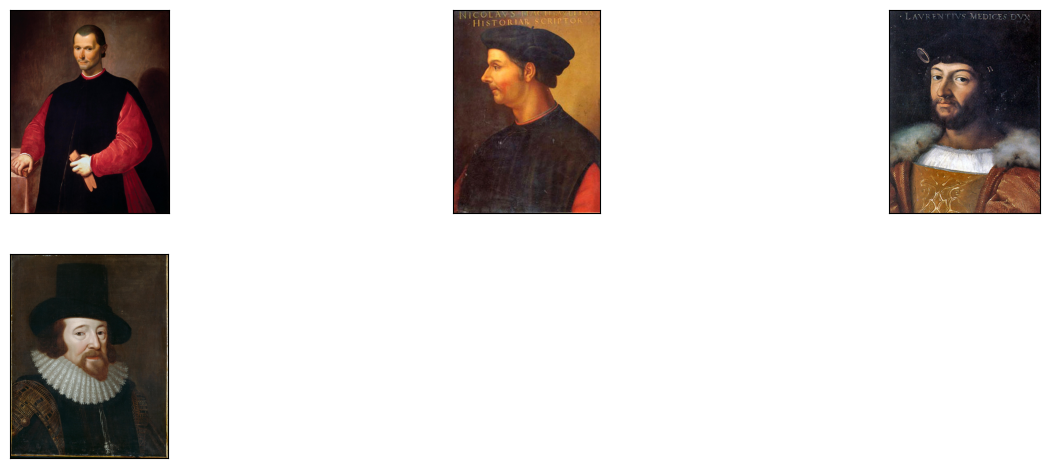

In [37]:
query_str = "Tell me about the machiavelli, where he lived and what he did?"

imgs, txts = retrieve(retriever_engine=retriever_engine, query_str=query_str)

# Show retrieved texts
context_str = "".join(txts)
print(context_str[:512])

# Show retrieved images
show_images(imgs)

## Multi Modal RAG

**Multi Modal Model: GPT-4o**

In [38]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

In [39]:
mm_model_name = "gpt-4o"
openai_mm_llm = OpenAIMultiModal(
    model=mm_model_name, api_key=os.environ["OPENAI_API_KEY"], max_new_tokens=1500
)

**Setting Prompt Template and Query Engine for MM-RAG**

In [40]:
from llama_index.core import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine

In [41]:
qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm,
    text_qa_template=qa_tmpl,
    vector_store_kwargs={
            "index" : "flat",
            },
)

**MM-RAG: Question Answering**

In [42]:
# Query by the user
query_str = "Tell me more about the machiavelli, where did he lived and what did he do?"

# Response from Multi Modal model
response = query_engine.query(query_str)

# Printing response
print(response.response)

Niccolò di Bernardo dei Machiavelli was a Florentine diplomat, author, philosopher, and historian who lived during the Italian Renaissance. He was born on 3 May 1469 and died on 21 June 1527. Machiavelli is best known for his political treatise "The Prince" (Il Principe), written around 1513 but published posthumously in 1532. He is often regarded as the father of modern political philosophy and political science.

Machiavelli lived in Florence, where he served as a senior official in the Florentine Republic, handling diplomatic and military affairs. He worked as secretary to the second chancery of the Republic of Florence from 1498 to 1512, during the period when the Medici family was out of power. After the Medici returned to power, Machiavelli was removed from office, accused of conspiracy, and imprisoned. Following his release, he retired to his farm estate at Sant'Andrea in Percussina, near San Casciano in Val di Pesa, where he focused on studying and writing political treatises.


**Showing the retrieved documents i.e images and text used for answering the query**

The Florentine city-state and the republic were dissolved, with Machiavelli then being removed from office and banished from the city for a year. In 1513, the Medici accused him of conspiracy against them and had him imprisoned. Despite being subjected to torture ("with the rope", in which the prisoner is hanged from his bound wrists from the back, forcing the arms to bear the body's weight and dislocating the shoulders), he denied involvement and was released after three weeks.
Machiavelli then retired to his farm estate at Sant'Andrea in Percussina, near San Casciano in Val di Pesa, where he devoted himself to studying and writing political treatises. During this period, he represented the Florentine Republic on diplomatic visits to France, Germany, and elsewhere in Italy. Despairing of the opportunity to remain directly involved in political matters, after a time he began to participate in intellectual groups in Florence and wrote several plays that (unlike his works on political th

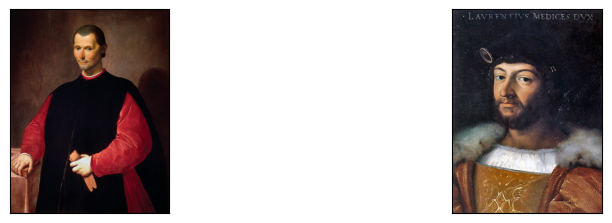

In [43]:
# Populate retrieved documents - texts and images
imgs = []
txts = []
for text_node in response.metadata["text_nodes"]:
    if text_node.text == '':
        imgs.append(text_node.metadata['file_path'].decode('utf-8'))
    else:
        txts.append(text_node.text)

# Display retrieved documents - texts and images
for txt in txts:
    print(txt)
show_images(imgs)

## Delete the KDB.AI Table
Once finished with the table, it is best practice to drop it.

In [44]:
texts_table.drop()
imgs_table.drop()